# V0 with adafactor 5 epochs

Install and import required libraries

In [1]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

/home/adg7899/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Tokenizer and Preprocess Data

In [3]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

In [4]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [5]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

In [6]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [7]:
# PEFT Config
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias = 'none',
    target_modules = ['query', 'value', 'out'],
    task_type="SEQ_CLS",
)

In [8]:
peft_model = get_peft_model(model, peft_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [9]:
#print("Trainable parameters:")
#for name, param in peft_model.named_parameters():
#  if param.requires_grad:
#    print(name)

In [10]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 888,580 || all params: 125,537,288 || trainable%: 0.7078


## Training Setup

In [11]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, average='weighted'),
        'recall': recall_score(labels, preds, average='weighted'),
        'f1': f1_score(labels, preds, average='weighted'),
    }

In [12]:
# Setup Training args
output_dir = "results"
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to=None,
    eval_strategy='epoch',
    logging_steps=100,
    learning_rate=2e-4,
    num_train_epochs=5,
    #max_steps=1200,
    use_cpu=False,
    dataloader_num_workers=4,
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    optim="adafactor",
    gradient_checkpointing=False,
    gradient_checkpointing_kwargs={'use_reentrant':True}
)

def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
      )

### Start Training

In [13]:
peft_lora_finetuning_trainer = get_trainer(peft_model)

result = peft_lora_finetuning_trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.225000,0.251873,0.918750,0.920165,0.918750,0.918304
2,0.180600,0.223191,0.929688,0.931743,0.929688,0.929900
3,0.203000,0.218508,0.940625,0.940974,0.940625,0.940635
4,0.206100,0.209169,0.940625,0.941459,0.940625,0.940692
5,0.174100,0.212668,0.942187,0.942976,0.942187,0.942271


## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [14]:
def classify(model, tokenizer, text):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
  output = model(**inputs)

  prediction = output.logits.argmax(dim=-1).item()

  print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
  return id2label[prediction]

In [15]:
# classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
# classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")

### Run Inference on eval_dataset

In [16]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [17]:
# Check evaluation accuracy
_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:03<00:00, 21.12it/s]


Evaluation Metric: {'accuracy': 0.9421875}


### Run Inference on unlabelled dataset

In [18]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map: 100%|██████████| 8000/8000 [00:05<00:00, 1386.81 examples/s]


Dataset({
    features: ['text'],
    num_rows: 8000
})

In [19]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"v0_adafactor_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [00:39<00:00, 25.10it/s]

Inference complete. Predictions saved to inference_output.csv


#Evaluation

Train & Validation Accuracy over time Plot

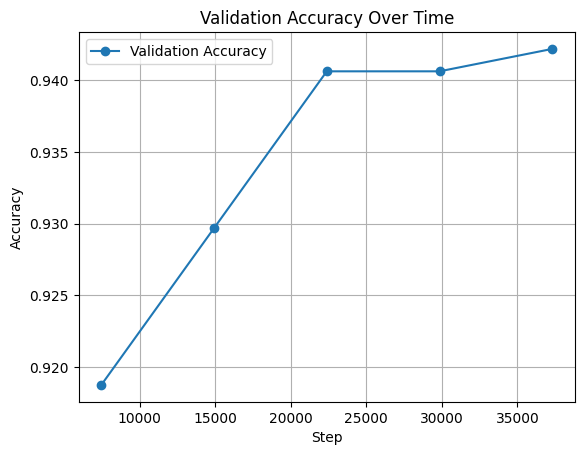

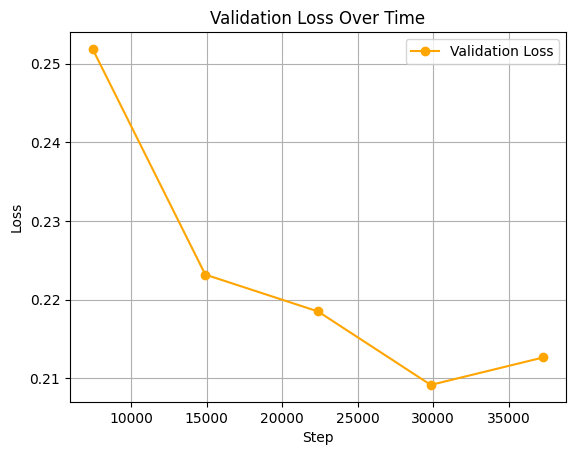

In [20]:
import matplotlib.pyplot as plt

# Access training log history
history = peft_lora_finetuning_trainer.state.log_history

# Extract steps and accuracy
eval_steps = [entry['step'] for entry in history if 'eval_accuracy' in entry]
eval_acc = [entry['eval_accuracy'] for entry in history if 'eval_accuracy' in entry]

# Extract eval loss (optional)
eval_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry]

# Plot validation accuracy
plt.plot(eval_steps, eval_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Plot validation loss too
plt.plot(eval_steps, eval_loss, label='Validation Loss', marker='o', color='orange')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()


Confusion Matrix

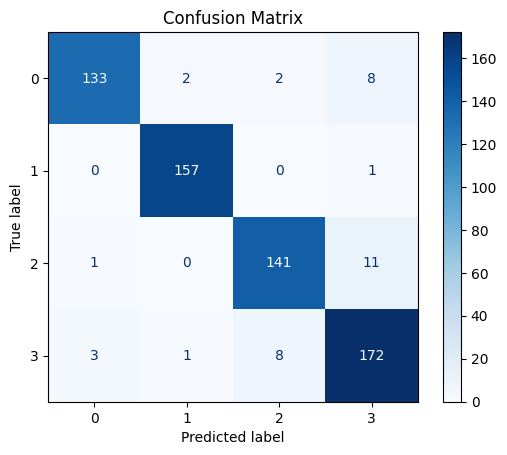

In [21]:
# predict on validation/test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
preds = peft_lora_finetuning_trainer.predict(eval_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=1)

# plot
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

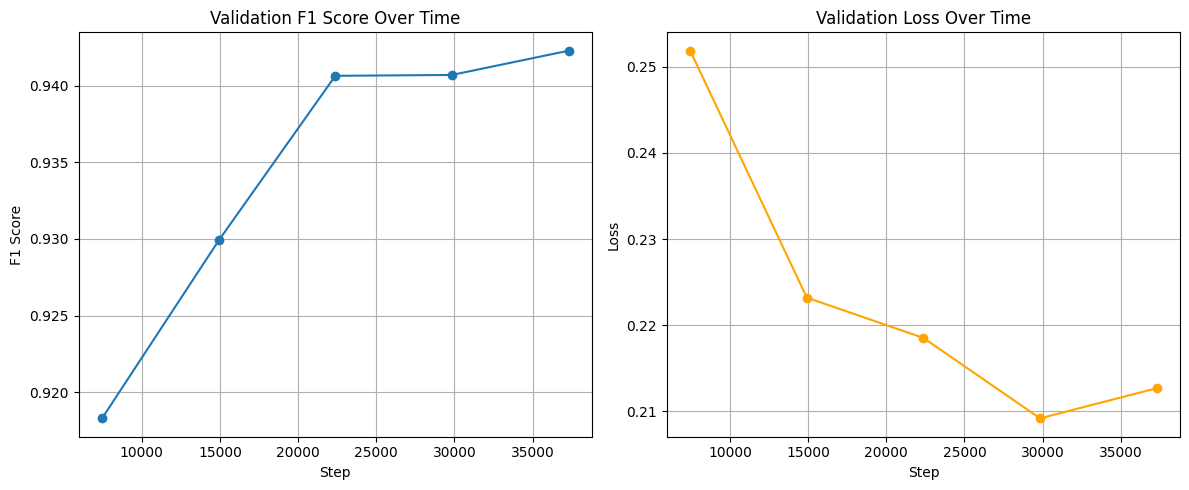

In [22]:
# Get training log history
log_history = peft_lora_finetuning_trainer.state.log_history

# Extract values from log
eval_steps = [entry['step'] for entry in log_history if 'eval_loss' in entry]
eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
eval_f1 = [entry['eval_f1'] for entry in log_history if 'eval_f1' in entry]

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# F1 Plot
plt.subplot(1, 2, 1)
plt.plot(eval_steps, eval_f1, marker='o')
plt.title("Validation F1 Score Over Time")
plt.xlabel("Step")
plt.ylabel("F1 Score")
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(eval_steps, eval_loss, marker='o', color='orange')
plt.title("Validation Loss Over Time")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from transformers import RobertaForSequenceClassification
from peft import PeftModel

base_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)
teacher_model = PeftModel.from_pretrained(base_model, "path/to/lora_checkpoint")
teacher_model.eval()

soft_labels = []

with torch.no_grad():
    for batch in train_dataloader:
        outputs = teacher_model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        soft_labels.append(torch.nn.functional.softmax(outputs.logits / temperature, dim=-1))  # soft targets


In [ ]:
import torch.nn as nn

class TinyTransformer(nn.Module):
    def __init__(self, vocab_size=30522, hidden_dim=128, n_heads=2, n_layers=2, num_labels=4, max_len=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.pos_embedding = nn.Embedding(max_len, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=n_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.classifier = nn.Linear(hidden_dim, num_labels)

    def forward(self, input_ids, attention_mask=None):
        pos_ids = torch.arange(0, input_ids.size(1)).unsqueeze(0).to(input_ids.device)
        x = self.embedding(input_ids) + self.pos_embedding(pos_ids)
        x = self.encoder(x)
        x = x.mean(dim=1)
        return self.classifier(x)


In [ ]:
def distillation_loss(student_logits, soft_labels, hard_labels, alpha=0.5, temperature=2.0):
    ce_loss = nn.CrossEntropyLoss()(student_logits, hard_labels)
    kl_loss = nn.KLDivLoss(reduction="batchmean")( 
        torch.nn.functional.log_softmax(student_logits / temperature, dim=1),
        soft_labels
    )
    return alpha * ce_loss + (1 - alpha) * (kl_loss * temperature * temperature)


In [ ]:
student_logits = student_model(input_ids=batch["input_ids"])
loss = distillation_loss(student_logits, soft_labels[idx], hard_labels=batch["labels"])


In [ ]:
student_preds = evaluate_model(student_model, test_dataset, False, 8, data_collator)

# Save predictions
df_student = pd.DataFrame({
    'ID': range(len(student_preds)),
    'Label': student_preds.numpy()
})
df_student.to_csv("results/student_predictions.csv", index=False)

# Save teacher and student model weights
torch.save(teacher_model.state_dict(), "results/teacher_model.pt")
torch.save(student_model.state_dict(), "results/student_model.pt")
